In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   |
| YrFireName                  |                                     
| Times_burned                |                                              
| Species                     |                                                     
| Genus_species               |                                       
| DBH_cm                      | 
| HT_m                        |
| CR_pre                      | 
| CR_post                     |

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1395082/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


In [3]:
# Filter to columns of interest
trees_dat = trees_dat[["yr1status", "YrFireName", "Times_burned", "Species", "Genus_species", 
                      "DBH_cm", "HT_m", "CR_pre", "CR_post"]]

# Change column names to lower snake case
trees_dat.columns = trees_dat.columns.str.lower()

# Check for incomplete observations (remove NAs)
trees_dat = trees_dat.dropna()

# Count number of observations
print("The number of observations after dropping NAs is", trees_dat.shape[0])

The number of observations after dropping NAs is 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [4]:
# Create a for loop factorizing categorical columns

for col in ['yrfirename', 'species', 'genus_species']:
    trees_dat[col],_ = pd.factorize(trees_dat[col], sort=True)
    
# View changes
trees_dat

,yr1status,yrfirename,times_burned,species,genus_species,dbh_cm,ht_m,cr_pre,cr_post
500,0.0,37,1,0,0,71.374,41.76,0.84,0.74
501,0.0,37,1,0,0,23.622,12.80,0.60,0.57
502,0.0,37,1,0,0,46.228,34.75,0.75,0.59
503,0.0,37,1,0,0,21.082,23.16,0.38,0.38
504,0.0,37,1,0,0,24.384,26.21,0.42,0.42
...,...,...,...,...,...,...,...,...,...
169332,0.0,33,1,31,31,32.512,15.54,0.90,0.90
169333,0.0,33,1,31,31,24.892,14.63,0.81,0.81
169334,0.0,33,1,31,31,32.258,16.46,0.85,0.63
169335,0.0,33,1,31,31,31.750,18.59,0.87,0.80


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [14]:
# Assign predictor and outcome variables 
X = trees_dat.loc[:, trees_dat.columns != 'yr1status']
Y = trees_dat[['yr1status']]

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)

# Scale the train and test features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [6]:
# Verify the training and testing set size
print("Training set observations:",len(X_train_scaled) )
print("Testing set observations:",len(X_test_scaled))

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [17]:
# Initialize model
model = LogisticRegression(random_state=42)

# Fit the model to the training data
model.fit(X_train_scaled, Y_train.values.ravel())

# Predict on the training data
y_train_pred = model.predict(X_train_scaled)

# Calculate accuracy
accuracy = accuracy_score(Y_train.values.ravel(), y_train_pred) # .ravel() used to flatten to prevent warning message

# Print accuracy
print(f"Training Accuracy: {accuracy:.3f}") 

Training Accuracy: 0.945


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [26]:
# Predict on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy_logistic = accuracy_score(Y_test.values.ravel(), y_test_pred)

# Print accuracy
print(f"Accuracy: {accuracy_logistic:.3f} ")

Accuracy: 0.940 


Confusion Matrix:


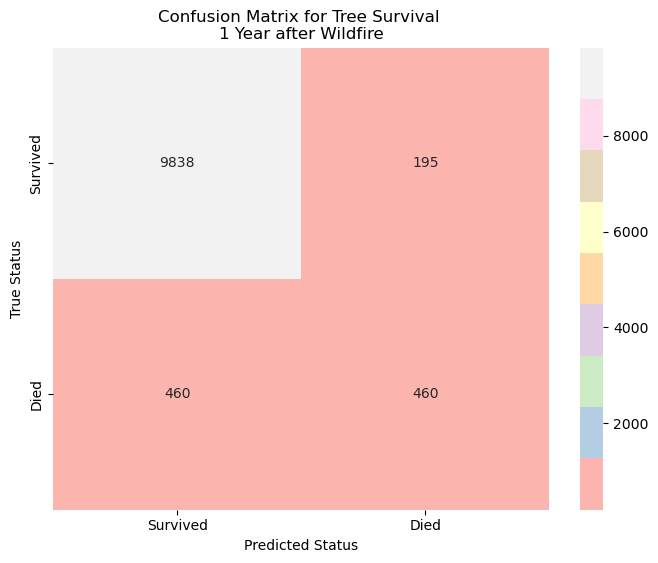

True positives (correctly predicted survival): 9838
True negatives (correctly predicted death): 460
False positives (incorrectly predicted survival): 460
False negatives (incorrectly predicted death): 195


In [31]:
# Calculate confusion matrix
cm = confusion_matrix(Y_test.values.ravel(), y_test_pred)
print(f"Confusion Matrix:")

# Plot confusion matrix

# Initialize figure
plt.figure(figsize=(8,6))

# Use seaborn to plot heatmap
sns.heatmap(cm, annot= True, fmt = 'd', cmap = 'Pastel1',
               xticklabels = ['Survived', 'Died'],
               yticklabels = ['Survived', 'Died'])
plt.title('Confusion Matrix for Tree Survival \n1 Year after Wildfire')
plt.ylabel('True Status')
plt.xlabel('Predicted Status')
plt.show()

# Calculate metrics
TP = cm[0,0]
TN = cm[1,1]
FP = cm[1,0]
FN = cm[0,1]

print(f"True positives (correctly predicted survival): {TP}")
print(f"True negatives (correctly predicted death): {TN}")
print(f"False positives (incorrectly predicted survival): {FP}")
print(f"False negatives (incorrectly predicted death): {FN}")

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model seemed to do well on the unseen data, as the majority of values are for true postives with an accuracy of 0.94. However, the model does perform differently on observations of trees surviving and dying. The model was correct on predicting surviving trees ~95.5% of the time (Sensitivty: TP/TP+FN, 9838/9838+460), whereas for predicting trees that died, the model was only correct ~70.2% (Specificity: TN/TN + FP, 460/460 + 195), meaning that the model was more accurate at identifying surviving trees. Yes, there is a class imbalance in this data set. In looking at the number of observations of surviving vs. dead trees, the data contains 94% surviving trees (9838+460/10953) and only 6% dead. This means the model was trained mostly on surviving trees.

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts the majority class of alive trees, the model would have similar accuracy because of how the data has a class imbalance and has most observations on surviving trees. However, the model would not be able to predict dead trees unlike the logistic regression model (70% > 0%). Therefore, the accuracy of the model would be slightly less than the logistric regression model.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.917

Dummy Confusion Matrix:


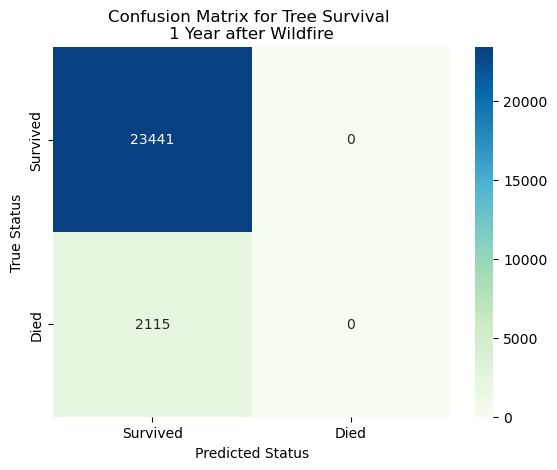

True positives (correctly predicted survival): 23441
True negatives (correctly predicted death): 0
False positives (incorrectly predicted survival): 2115
False negatives (incorrectly predicted death): 0


In [36]:
# Make dummy model 
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

# Fit the DummyClassifier on the training data
dummy_model.fit(X_train_scaled, Y_train.values.ravel())

# Predict on the training set
y_train_pred_dummy = dummy_model.predict(X_train_scaled)

# Generate the confusion matrix
cm_dummy = confusion_matrix(Y_train.values.ravel(), y_train_pred_dummy)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {accuracy_score(Y_train.values.ravel(), y_train_pred_dummy):.3f}")
print("\nDummy Confusion Matrix:")

# Use seaborn to plot heatmap
sns.heatmap(cm_dummy, annot= True, fmt = 'd', cmap = 'GnBu',
               xticklabels = ['Survived', 'Died'],
               yticklabels = ['Survived', 'Died'])
plt.title('Confusion Matrix for Tree Survival \n1 Year after Wildfire')
plt.ylabel('True Status')
plt.xlabel('Predicted Status')
plt.show()


# Calculate metrics
TP_d = cm_dummy[0,0]
TN_d = cm_dummy[1,1]
FP_d = cm_dummy[1,0]
FN_d = cm_dummy[0,1]

print(f"True positives (correctly predicted survival): {TP_d}")
print(f"True negatives (correctly predicted death): {TN_d}")
print(f"False positives (incorrectly predicted survival): {FP_d}")
print(f"False negatives (incorrectly predicted death): {FN_d}")

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [10]:
# Logistic classifier AUC

# Get predicted probabilities for logistic regression on test set
y_test_prob_logistic = model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, _ = roc_curve(Y_test.values.ravel(), y_test_prob_logistic)

# Compute AUC for logistic regression on test set
auc_logistic = roc_auc_score(Y_test.values.ravel(), y_test_prob_logistic)

print(f"Logistic AUC: {auc_logistic:.3f}")

Logistic AUC: 0.918


In [11]:
# Get predicted probabilities for the dummy model on the test set
y_test_prob_dummy = dummy_model.predict_proba(X_test_scaled)[:, 1]
fpr_dummy, tpr_dummy, _ = roc_curve(Y_test.values.ravel(), y_test_prob_dummy)

# Compute AUC for dummy model on test set
auc_dummy = roc_auc_score(Y_test.values.ravel(), y_test_prob_dummy)

print(f"Dummy AUC: {auc_dummy} ")

Dummy AUC: 0.5 


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

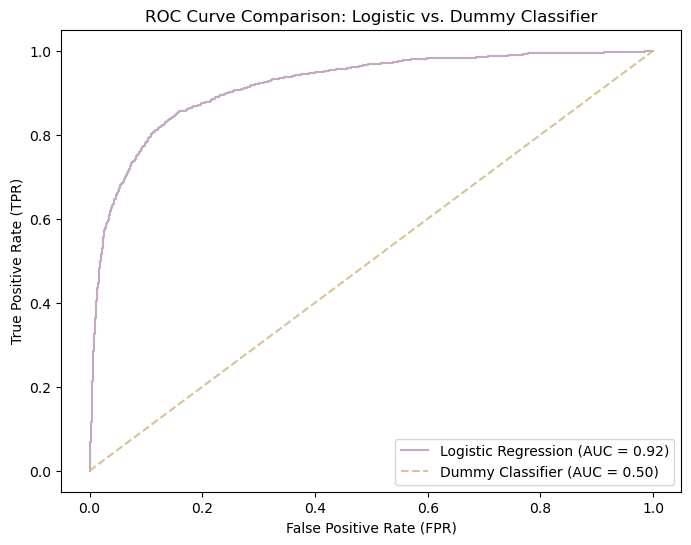

In [12]:
# ROC curve for logistic and dummy classifier

# Initialize plot
plt.figure(figsize = (8,6))

# Plot heatmaps for both classifiers
plt.plot(fpr_logistic, tpr_logistic, color="#C4A9C2", label=f"Logistic Regression (AUC = {auc_logistic:.2f})")
plt.plot(fpr_dummy, tpr_dummy, color="#D8C397", linestyle="--", label=f"Dummy Classifier (AUC = {auc_dummy:.2f})")

# Labels
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Comparison: Logistic vs. Dummy Classifier")
plt.legend(loc="lower right")

# Show the plot
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

*Your answer here*

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [41]:
# Create df of features and coefficients

# Define feature names and coefficients
feature_names = X.columns.tolist()
coefficients = model.coef_[0]

# Place into df
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients})

# Sort by abs val for coef
feature_importance['Abs_Coef'] = abs(feature_importance['Coefficient'])

# Assign sorted feature importance
importance_df = feature_importance.sort_values('Abs_Coef', ascending=False)

# Print the sorted feature importance
print(importance_df)

         Feature  Coefficient  Abs_Coef
7        cr_post    -2.494974  2.494974
5           ht_m    -1.165414  1.165414
0     yrfirename    -0.660497  0.660497
2        species     0.541509  0.541509
4         dbh_cm     0.421324  0.421324
6         cr_pre     0.123414  0.123414
3  genus_species    -0.067867  0.067867
1   times_burned     0.000000  0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

In this model, the most important features were the post-fire live crown ratio then the pre-fire tree height (m).